# Stock Trades vs. Geographic Regions Classification Project

This project uses public data about the stock trades made by members of the US House of Representatives. This data is collected and maintained by Timothy Carambat as part of the [House Stock Watcher](https://housestockwatcher.com/) project. 

## Summary of Findings


### Introduction

In this project, we are attempting to answer the question of whether or not we can predict the geographic region that a U.S. representative comes from using informations about their stock trade. This is a classification problem with our target variable being the greographic region, which contains 4 categories: Midwest, West, Northest, and South. We are grouping the districts into geographic regions to reduce the complexity of the classification task, and we will be using F1 score as our evaluation metric for the classification model.

### Baseline Model
In our baseline model, we used five features: `'disclosure_year'` (ordinal), `'owner'` (nominal), `'type'` (nominal), `'amount'` (ordinal), and `'cap_gains_over_200_usd'` (nominal).

As a measure of the accuracy of our model, the f1-score for the training subset is approximately 0.54 and the score for the testing subset is around 0.53. Both scores are very low, but given that we have 4 categories, it is an okay score to start with. The gap between the two scores is very small, which meant that the model is not overfitting. But since both scores are relatively low, it suggests that we need to be more selective and apply more effective transformations to prediction vairables to improve the model's accuracy. Although the baseline model doesn't show signs of overfitting, the model may improve in accuracy if we increase the complexity. Therefore, we would still need to perform a Grid Search to determine the best combination of values for the hyperparameters of our model. 

### Final Model

In our final model, we added 2 features by transforming the columns `'ticker'` and `'asset_description'`. For `'ticker'`, due to the large number of unique tickers in our dataset, we couldn't just apply one-hot encoding to the values. Therefore, we categorized the stocks into 3 ordinal groups by the number of times each ticker is traded within this dataset. The tickers that have been traded for over 10 times are in group 3; the tickers that have been traded between 1 and 10 times are in group 2, and the rest that have only been traded once are in group 1. This may help our classification algroithm in that the number of times a stock is traded may be related to the popularity and size of the company, which may have some relationship to the geographical locations.

For the column `'asset_description'`, we applied a CountVectorizer to transform the descriptions with a bag-of-words approach because we discovered that each entry contained important keywords that describes the business. The addition of this feature improves our model since it will be able to represent the relatedness of stocks given the keyword vectors. 

In addition, we also performed a grid search to find the best combination of values for the hyperparameters for our Random Forest Classifier. The hyperparameter values we found to perform the best are {'clf__max_depth': 100, 'clf__n_estimators': 500}

We picked Random Forest Classifier to use as our model because we have a relatively large dataset, and the complexity of the relationships between the predictor variables and geographic locations suggests that we would need to build a relatively complex model. Since Random Forest is essentially made of multiple decision trees, we decided that it would be a better fit for this classification problem.


### Fairness Evaluation

We performed an accuracy parity test on our classification model on the amount of money traded in relation to the accuracy of the classifications made. We decided to use accuracy as our parity measure due to the nature of our classification problem. Since we have 4 geographic regions to classify the trades into, recall and precision scores would be hard to compute and a bit irrelevant and nonrepresentational as a parity measure of this problem. Therefore, we chose accuracy as our measure to determine whether or not our classification model is fair for trades that were traded for over 15,000 USD and those that were traded for a lesser amount. With a p-value of 0.0, we have found that our model is not fair in regards to the trading amount and that it makes more accurate classifications when the trading amount is large.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Building a Baseline Model

#### Taking a look at our dataset:

In [2]:
transactions = pd.read_csv('all_transactions.csv')
transactions.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


In [3]:
transactions['disclosure_year'].value_counts()

2020    7379
2021    5520
2022    2800
Name: disclosure_year, dtype: int64

#### Our dataset have 15699 rows of data, each containing information of a trade taken by a Congress representative.

In [4]:
transactions.shape

(15699, 12)

We will need to first transform the district column into **geographic regions** -- our target variable

In [5]:
transactions['region'] = transactions['district'].transform(lambda x: x[:2])

midwest = ['MI', 'KS', 'ND', 'MO', 'IN', 'MN', 'SD', 'WI', 'OH', 'IA', 'NE', 'IL']
south = ['TX', 'LA', 'GA', 'SC', 'WV', 'OK', 'MS', 'FL', 'NC', 'VA', 'AR', 'AL', 'TN', 'KY', 'GU']
west = ['WA', 'NV', 'WY', 'CO', 'OR', 'ID', 'UT', 'NM', 'CA', 'MT', 'AZ', 'AK', 'HI']
northeast = ['PA', 'DC', 'NJ', 'MA', 'NY', 'MD', 'CT', 'VT', 'ME', 'DE', 'RI', 'NH']

transactions.loc[transactions['region'].isin(midwest), 'region'] = 'midwest'
transactions.loc[transactions['region'].isin(south), 'region'] = 'south'
transactions.loc[transactions['region'].isin(west), 'region'] = 'west'
transactions.loc[transactions['region'].isin(northeast), 'region'] = 'northeast'

df = transactions
df

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,region
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,south
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,south
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,south
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,south
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,west
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15694,2020,06/10/2020,2020-04-09,--,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,west
15695,2020,06/10/2020,2020-04-09,--,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,west
15696,2020,06/10/2020,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,south
15697,2020,06/10/2020,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,south


#### Taking a look at the distribution of trades in each region.

In [6]:
df['region'].value_counts()

south        6187
west         4822
northeast    2885
midwest      1805
Name: region, dtype: int64

Since there is no major unbalance in the distribution of the regions across all trades, we won't have to worry too much about the bias of our model training it on this dataset.

#### To filter out irrelevant variables, we will first drop these columns from our dataset to narrow down the number of prediction variables.

In [7]:
df = df.drop(columns=['disclosure_date', 'transaction_date', 'representative', 'district', 'ptr_link', 'asset_description'])
df.head()

,disclosure_year,owner,ticker,type,amount,cap_gains_over_200_usd,region
0,2021,joint,BP,purchase,"$1,001 - $15,000",False,south
1,2021,joint,XOM,purchase,"$1,001 - $15,000",False,south
2,2021,joint,ILPT,purchase,"$15,001 - $50,000",False,south
3,2021,joint,PM,purchase,"$15,001 - $50,000",False,south
4,2021,self,BLK,sale_partial,"$1,001 - $15,000",False,west


All columns except for `'disclosure_year'` contain categorical and ordinal values; therefore, we need to transform them into numerical before we can run prediction models on them.

In [9]:
(df['disclosure_year'].isna().sum(),
df['owner'].isna().sum(),
df['ticker'].isna().sum(), 
df['amount'].isna().sum(),
df['cap_gains_over_200_usd'].isna().sum(),
df['region'].isna().sum())

(0, 6032, 0, 0, 0, 0)

Since there are a large number of missing values in the `'owner'` column and `'ticker'` column, we chose to put them into a separate category of 'missing' in order to maintain the size of the dataset and the relative distribution of trades across the 4 regions.

In [10]:
df.loc[(df['owner'] == '--') | (df['owner'].isna()), 'owner'] = 'missing'
df.head()

,disclosure_year,owner,ticker,type,amount,cap_gains_over_200_usd,region
0,2021,joint,BP,purchase,"$1,001 - $15,000",False,south
1,2021,joint,XOM,purchase,"$1,001 - $15,000",False,south
2,2021,joint,ILPT,purchase,"$15,001 - $50,000",False,south
3,2021,joint,PM,purchase,"$15,001 - $50,000",False,south
4,2021,self,BLK,sale_partial,"$1,001 - $15,000",False,west


In [11]:
df.loc[(df['ticker'] == '--') | (df['ticker'].isna()), 'owner'] == 'missing'
df.head()

,disclosure_year,owner,ticker,type,amount,cap_gains_over_200_usd,region
0,2021,joint,BP,purchase,"$1,001 - $15,000",False,south
1,2021,joint,XOM,purchase,"$1,001 - $15,000",False,south
2,2021,joint,ILPT,purchase,"$15,001 - $50,000",False,south
3,2021,joint,PM,purchase,"$15,001 - $50,000",False,south
4,2021,self,BLK,sale_partial,"$1,001 - $15,000",False,west


In [12]:
df.shape

(15699, 7)

#### Now we can look at the type and distribution of values within each column to decide the transformations to apply to quantify them.

In [13]:
df['owner'].value_counts()

missing      7347
joint        4939
self         3013
dependent     400
Name: owner, dtype: int64

For the `'owner'` column, we will simply use **one-hot encoding** to transform the data into numerical given that there are only 4 categories.

In [14]:
df['ticker'].value_counts()

--       1296
MSFT      265
AAPL      187
NTAP      141
TDDXX     122
         ... 
PEGI        1
IAC         1
RF$A        1
NUGL        1
FCGAX       1
Name: ticker, Length: 2219, dtype: int64

For the `'ticker'` column, there are **1439** total unique tickers traded within this dataset, which is way too many for one-hot encoding. Therefore we will drop this column in the building of our baseline model and will further explore more effective transformations in the later section when we build our final model.

And for the `'amount'` column, due to the ordinal nature of the values, we will use **ordinal encoding** to transform its values.

In [15]:
df['amount'].value_counts()

$1,001 - $15,000            11006
$15,001 - $50,000            2539
$50,001 - $100,000            788
$100,001 - $250,000           594
$250,001 - $500,000           268
$1,001 -                      243
$500,001 - $1,000,000         162
$1,000,001 - $5,000,000        51
$1,000,000 +                   30
$5,000,001 - $25,000,000        9
$1,000 - $15,000                4
$15,000 - $50,000               3
$50,000,000 +                   1
$1,000,000 - $5,000,000         1
Name: amount, dtype: int64

Notice that some different values in `'amount'` column represent the same thing, so we group them to avoid redundancy. In order to specify the current order when using ordinal encoding transformation, we represent each range with its minimum number.

In [16]:
df['amount'] = df['amount'].apply(lambda x: x[(x.index('$')+1):(x.index(' '))])
df['amount'] = df['amount'].replace({'1,000':'1,001','15,000':'15,001','1,000,000':'1,000,001'})
amount_order = ['1,001','15,001','50,001','100,001','250,001','500,001','1,000,001','5,000,001','50,000,000']

In [17]:
df['cap_gains_over_200_usd'].value_counts()

False    14734
True       965
Name: cap_gains_over_200_usd, dtype: int64

Lastly, we will use **one-hot encoding** to transform the boolean values in column `'cap_gains_over_200_usd'`.

#### Baseline Model

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

Here we divide the dataset into a **75%** train subset and **25%** test subset.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['region','ticker']), 
                                                    df['region'], random_state=1)

Then, we apply different transformations to the different columns using **ColumnTransformer** and build a **random forest classifier**.

In [20]:
ct_base = ColumnTransformer(transformers = [
                           ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['owner', 'cap_gains_over_200_usd', 'type']),
                           ('year_oe', OrdinalEncoder(), ['disclosure_year']),
                           ('amount_oe', OrdinalEncoder(categories=[amount_order]), ['amount'])],
                           remainder='passthrough')

In [21]:
pl_base = Pipeline([('Preprocessor', ct_base), ('clf', RandomForestClassifier())])
pl_base.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['owner',
                                                   'cap_gains_over_200_usd',
                                                   'type']),
                                                 ('year_oe', OrdinalEncoder(),
                                                  ['disclosure_year']),
                                                 ('amount_oe',
                                                  OrdinalEncoder(categories=[['1,001',
                                                                              '15,001',
                                                                              '50,001',
                                                                              '10

Now take a look at the **f1-score** of training set and test set.

In [23]:
base_train = pl_base.score(X_train, y_train)
base_test = pl_base.score(X_test, y_test)
print(f'baseline model training score:{base_train}\nbaseline model test score:{base_test}')

baseline model training score:0.5441651095634449
baseline model test score:0.5352866242038217


#### Both scores are very low, which indicates that we would need to take a more precise and elaborate approach.

## Final Model

#### For our final model, we will engineer 2 features as well as perform a gridsearch to improve the accuracy.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [25]:
df.head()

,disclosure_year,owner,ticker,type,amount,cap_gains_over_200_usd,region
0,2021,joint,BP,purchase,"1,001",False,south
1,2021,joint,XOM,purchase,"1,001",False,south
2,2021,joint,ILPT,purchase,"15,001",False,south
3,2021,joint,PM,purchase,"15,001",False,south
4,2021,self,BLK,sale_partial,"1,001",False,west


#### To effectively transform the `'ticker'` column into numerical values, we need to come up with a metric for grouping similar tickers together. 
Here, we will use the number of times each ticker is traded (trading volumn) as our measure to categorize the tickers into 3 groups:
- **low**: tickers that have been traded only once & the stocks with missing 'ticker' names (we denote it with 1)
- **medium**: tickers that have been traded between 2 and 10 times (we denote it with 2)
- **high**: tickers that have been traded more than 10 times (we denote it with 3)

#### We will need to write a custom transformer that does the grouping when we train and test our model on actual data.

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin

class TransformTicker(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        df = pd.DataFrame(X)
        df['ticker'] = df['ticker'].apply(lambda x: 3 if df[df['ticker'] == x].shape[0] > 10 
                                          else 2 if df[df['ticker'] == x].shape[0] > 1 else 1)
        
        return df


In column `'asset_description'`, each entry contains a short description of the type of business the stock is in. Therefore, a **countvectorizer** that does a bag-of-words transformation would be the most appropriate in this case.

In [28]:
lst = []
for i in transactions['asset_description']:
    lst.append(i)
lst[:30]

['BP plc',
 'Exxon Mobil Corporation',
 'Industrial Logistics Properties Trust - Common Shares of Beneficial Interest',
 'Phillip Morris International Inc',
 'BlackRock Inc',
 'American Express Company',
 'Katapult Holdings Inc - Warrant',
 'Advanced Micro Devices Inc',
 'Apple Inc',
 'Microsoft Corporation',
 'Morgan Stanley',
 'NextEra Energy Inc',
 'Sylvamo Coproration',
 'The Carlyle Group Inc',
 'Altria Group Inc',
 'Duke Energy Corporation 5.125% Junior Subordinated Debentures due 2073',
 'GlaxoSmithKline PLC',
 'One Liberty Properties Inc',
 'PPL Corporation',
 'Sculptor Capital Management Inc Class A',
 'Sculptor Capital Management Inc Class A',
 'Via Renewables Inc - 8.75% Series A Fixed-to-Floating Rate Cumulative Redeemable Perpetual Preferred Stock',
 'Coinbase Global Inc',
 'Harris County TX 5%',
 'Main Mun Bd BK 5% 09/01/27',
 'New York St 5% 06/15/27',
 'Utility Debt NY 5% 12/15/29',
 'ACADIA Pharmaceuticals Inc',
 'AGNC Investment Corp',
 'Allakos Inc']

In [29]:
# Add the 'asset_description' column back to df
df['asset'] = transactions['asset_description']

# Adjust the asset_description column for CountVectorizer to work
df['asset'] = df['asset'].fillna(' ')

In [30]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(df.drop(columns=['region']), 
                                                                            df['region'], random_state=1)

In [31]:
ct_final = ColumnTransformer(transformers = [
                       ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['owner', 'cap_gains_over_200_usd', 'type']),
                       ('year_oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), ['disclosure_year']),
                       ('amount_oe', OrdinalEncoder(categories=[amount_order],handle_unknown='use_encoded_value', unknown_value=np.nan), ['amount']),
                       ('ticker', TransformTicker(), ['ticker']),
                       ('cv', CountVectorizer(), 'asset')],
                       remainder='passthrough')

In [32]:
pl_new = Pipeline([('Preprocessor', ct_final), ('clf', RandomForestClassifier())])
pl_new.fit(X_train_final, y_train_final)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['owner',
                                                   'cap_gains_over_200_usd',
                                                   'type']),
                                                 ('year_oe',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['disclosure_year']),
                                                 ('amount_oe',
                                                  OrdinalEncoder(categories=[['1,001',
                                                                              '15,001',
 

In [33]:
pl_new.score(X_test_final, y_test_final)

0.7230573248407643

### Grid Search for Hyperparameter Tuning

In [40]:
hyperparameters = {'clf__n_estimators': [50, 100, 300, 500, 1000],
                   'clf__max_depth': [5, 15, 25, 50, 100]}

searcher = GridSearchCV(pl_new, hyperparameters, cv=3)

To reduce the computational load of the grid search, we will cut the size of the dataset by half by random sampling half of the data to include in our search.

In [41]:
df_grid = df.sample(frac=0.5).reset_index(drop=True)

In [42]:
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(df_grid.drop(columns=['region']), 
                                                                            df_grid['region'], random_state=1)

In [43]:
searcher.fit(X_train_grid, y_train_grid)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one-hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['owner',
                                                                          'cap_gains_over_200_usd',
                                                                          'type']),
                                                                        ('year_oe',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=nan),
                                                              

In [44]:
searcher.best_params_

{'clf__max_depth': 100, 'clf__n_estimators': 500}

In [45]:
searcher.score(X_test_final, y_test_final)

0.7882802547770701

After running grid search, we discovered the best hyperparameter values, which we will use to improve on our final model.

In [46]:
pl_final = Pipeline([('Preprocessor', ct_final), ('clf', RandomForestClassifier(n_estimators=500, max_depth=100))])
pl_final.fit(X_train_final, y_train_final)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['owner',
                                                   'cap_gains_over_200_usd',
                                                   'type']),
                                                 ('year_oe',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['disclosure_year']),
                                                 ('amount_oe',
                                                  OrdinalEncoder(categories=[['1,001',
                                                                              '15,001',
 

Now take a look at the **f1-score** of the training set and test set again of our improved model.

In [60]:
final_train = pl_final.score(X_train_final, y_train_final)
final_test = pl_final.score(X_test_final, y_test_final)
print(f'final model training score:{final_train}\nfinal model test score:{final_test}')

final model training score:0.9453032104637337
final model test score:0.726624203821656


#### Our final test accuracy score is 0.727

### Fairness Evaluation

#### In this section, we will perform an accuracy parity test on the trading amount through a permutation test to measure if our model is fair to predict the geographic regions of trades taken in either high or low amount.

We will classify trading amounts above $15,000 to be large amount and any trading amount below to be small amount.
- **Null Hypothesis**: The model's accuracy is the same for large-amount and small-amount trades, and any differences are due to chance.
- **Alternative Hypothesis**: The classifier's accuracy for large-amount trades is not the same as the accuracy for small-amount trades.
- Test statistic: Difference in accuracy (large - small).
- Significance level: 0.05.

In [48]:
df['amount'].value_counts()

1,001         11253
15,001         2542
50,001          788
100,001         594
250,001         268
500,001         162
1,000,001        82
5,000,001         9
50,000,000        1
Name: amount, dtype: int64

In [50]:
X_test_final['region'] = y_test_final
X_test_final['preds'] = pl_final.predict(X_test_final.drop(columns=['region']))
X_test_final['large_amount'] = (X_test_final.amount.isin(['1,001'])).replace({True: False, False: True})
X_test_final.head()

,disclosure_year,owner,ticker,type,amount,cap_gains_over_200_usd,asset,region,preds,large_amount
1966,2022,missing,AMGN,purchase,"1,001",False,Amgen Inc,south,south,False
10871,2021,joint,KMX,sale_full,"1,001",False,CarMax Inc,west,west,False
8491,2020,self,--,purchase,"250,001",False,Bay area Toll RV Ca Toll Tran,west,west,True
5044,2021,self,CVET,purchase,"1,001",False,Covetrus,midwest,west,False
13782,2022,joint,--,purchase,"250,001",False,Illinois ST Sales Tax Rev JS Oblig 4% Due 06/1...,west,west,True


In [51]:
(X_test_final['preds'] == X_test_final['region']).mean()

0.7245859872611465

In [52]:
# observed score
obs = X_test_final.groupby('large_amount').apply(lambda X_test_final: metrics.accuracy_score(
        X_test_final['preds'], X_test_final['region'])).diff().iloc[-1]
obs

0.12587947037061076

In [53]:
X_test_final.groupby('large_amount').apply(lambda X_test_final: metrics.accuracy_score(X_test_final['preds'], X_test_final['region']))

large_amount
False    0.689789
True     0.815668
dtype: float64

Permutation of 100 rounds:

In [54]:
deviations = []
for _ in range(100):
    s = (
        X_test_final[['large_amount', 'preds', 'region']]
        .assign(large_amount=X_test_final.large_amount.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('large_amount')
        .apply(lambda X_test_final: metrics.accuracy_score(X_test_final['preds'], X_test_final['region']))
        .diff()
        .iloc[-1]
    )
    deviations.append(s)

#### P-value

In [55]:
(deviations > obs).mean()

0.0

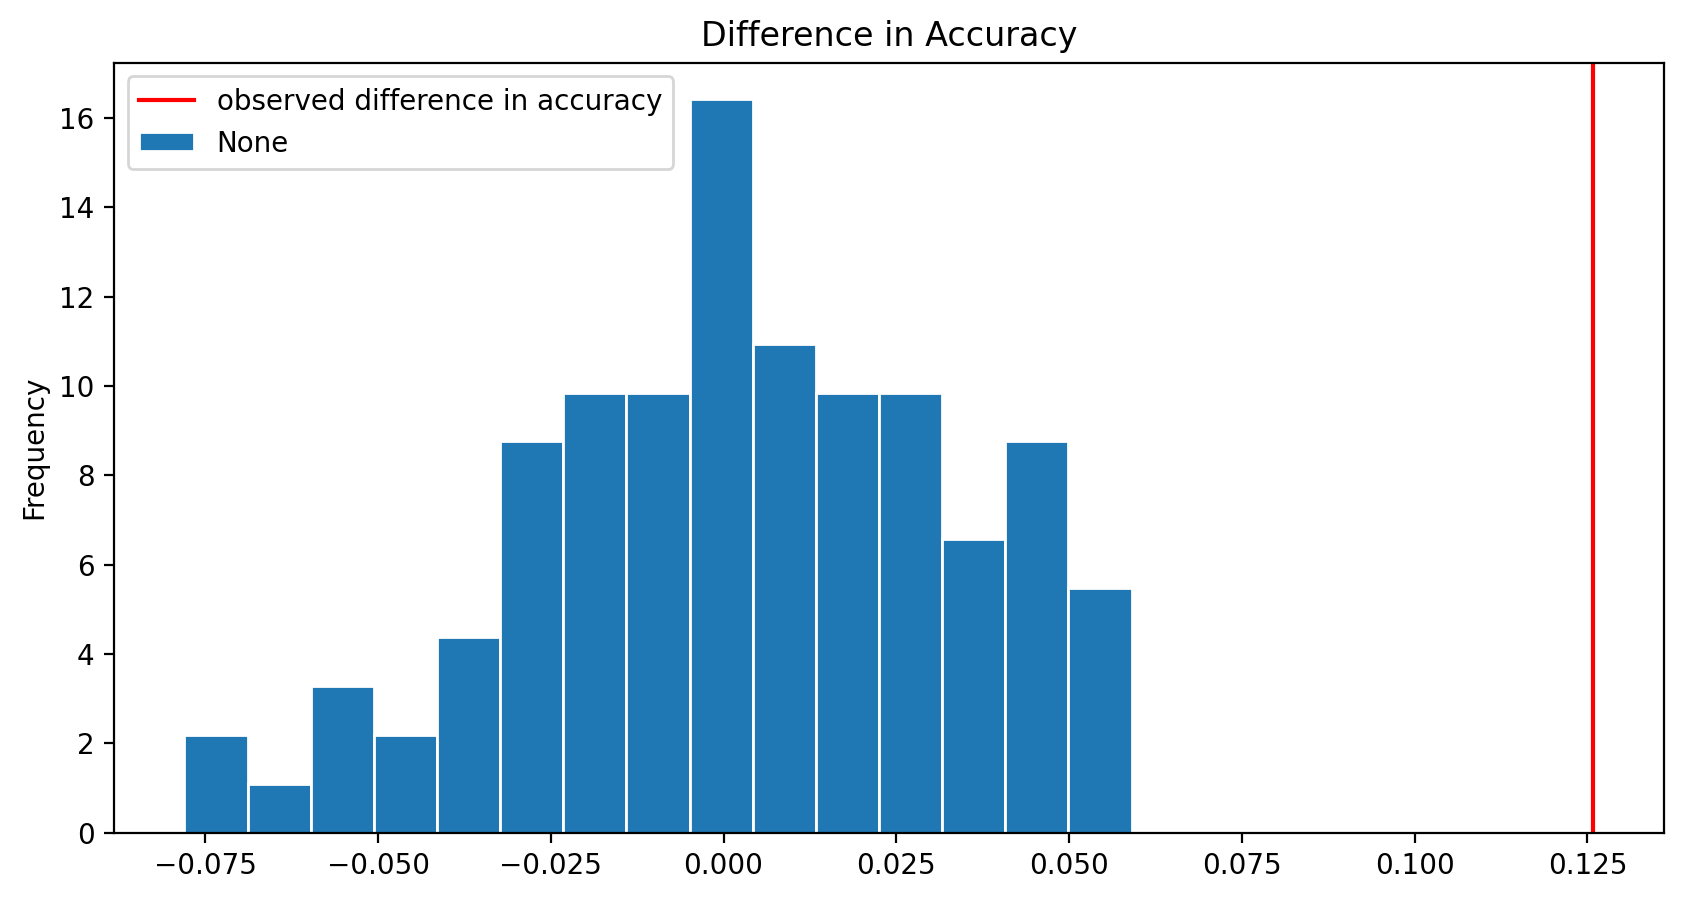

In [56]:
plt.figure(figsize=(10, 5))
pd.Series(deviations).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Accuracy')
plt.axvline(x=obs, color='red', label='observed difference in accuracy')
plt.legend(loc='upper left');

### Conclusion:
With a p-value of 0.0 and a significance level of 0.05, we reject the null and conclude that our classification model is not fair in regards to the amount of money traded using accuracy as oue measure. The result of our permutation test suggests that the trades with trading amount of over 15,000 have higher accuracy of correctly classifying the geographic location that the representative who took that trade reside in. Therefore, with regards to the trading amount, our classification model is not fair.

For future improvement of the model, we would be more selective with the training dataset and ensure that for each prediction variable that we are using, there isn't a notable unbalance within the categories. This would reduce the possibility of building a model that compromises fairness. In the meantime, we would look for ways to increase the accuracy of our classification model. Since our final model's training score was very high while our test score was mediocre, this means that there's a high possibility that our model is overfitting on the training data. So in order to improve the model's performance, a further tuning of the hyperparameters is needed. 